<a href="https://colab.research.google.com/github/Jade-P/MLGroupProject/blob/Happy--Sohyun/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Environment & path Setup 

In [1]:
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1fr1dJI9LyphQ6Y0Wo_au1ymvUsZnNvXD' 


download = drive.CreateFile({'id': file_id})


# Download the file to a local disc
download.GetContentFile('preprocessed.zip')

In [3]:
!unzip -qq preprocessed.zip

#Load Data

In [4]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import tensorflow as tf
import matplotlib.pyplot as plt
RANDOM_SEED = 123

In [5]:
TRAIN_DIR = ('Training/Training/')
TEST_DIR = ('Testing/Testing/')

In [6]:
emotions = ['Angry', 'Fear', 'Happy', 'Neutral', 'Sad', 'Suprise']

In [7]:
def load_data(dir_path, IMG_SIZE):
   
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(emotions)):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file, cv2.IMREAD_GRAYSCALE)
                    img = img.astype('float32') / 255
                    resized = cv2.resize(img, IMG_SIZE, interpolation = cv2.INTER_AREA)
                    X.append(resized)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [8]:
IMG_SIZE= (48, 48)

In [9]:
X_train, y_train, train_labels = load_data(TRAIN_DIR, IMG_SIZE)

100%|██████████| 6/6 [00:03<00:00,  1.69it/s]


36854 images loaded from Training/Training/ directory.


In [10]:
train_labels

{0: 'Angry', 1: 'Fear', 2: 'Happy', 3: 'Neutral', 4: 'Sad', 5: 'Suprise'}

In [11]:
X_test, y_test, test_labels = load_data(TEST_DIR,IMG_SIZE)

100%|██████████| 6/6 [00:00<00:00, 13.15it/s]

7067 images loaded from Testing/Testing/ directory.


In [12]:
X_train.shape

(36854, 48, 48)

#Model Building

In [17]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

In [19]:
from keras.utils import to_categorical

Y_train = to_categorical(y_train, num_classes=6)
Y_train.shape

(36854, 6)

In [20]:
Y_test = to_categorical(y_test, num_classes=6)
Y_test.shape

(7067, 6)

In [56]:
from keras.applications.vgg19 import VGG19

base_model = VGG19(
        weights=None,
        include_top=False, 
        input_shape=IMG_SIZE + (1,)
    )

base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        640       
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [57]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

In [58]:
NUM_CLASSES = 6

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1000, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(NUM_CLASSES, activation="softmax"))

In [59]:
def deep_model(model, X_train, Y_train, epochs, batch_size, validation_data):
   
    model.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(learning_rate=1e-4),
    metrics=['accuracy'])
    
    history = model.fit(X_train
                       , Y_train
                       , epochs=epochs
                       , batch_size=batch_size
                       , validation_data=(validation_data)
                       , verbose=1
                       , workers=16
                       , steps_per_epoch=len(X_train) // batch_size + 1)
    return history

In [60]:
X_train.shape

(36854, 48, 48)

In [61]:
epochs = 20
batch_size = 64

history = deep_model(model, X_train, Y_train, epochs, batch_size, validation_data=(X_test, Y_test))

Epoch 1/20
576/576 [==============================] - 50s 84ms/step - loss: 1.7620 - accuracy: 0.2139 - val_loss: 1.6468 - val_accuracy: 0.3049
Epoch 2/20
576/576 [==============================] - 48s 83ms/step - loss: 1.5841 - accuracy: 0.3393 - val_loss: 1.4232 - val_accuracy: 0.4268
Epoch 3/20
576/576 [==============================] - 48s 84ms/step - loss: 1.4270 - accuracy: 0.4129 - val_loss: 1.2984 - val_accuracy: 0.4866
Epoch 4/20
576/576 [==============================] - 48s 84ms/step - loss: 1.3038 - accuracy: 0.4698 - val_loss: 1.2099 - val_accuracy: 0.5186
Epoch 5/20
576/576 [==============================] - 48s 84ms/step - loss: 1.2164 - accuracy: 0.5091 - val_loss: 1.1912 - val_accuracy: 0.5264
Epoch 6/20
576/576 [==============================] - 48s 84ms/step - loss: 1.1472 - accuracy: 0.5385 - val_loss: 1.1666 - val_accuracy: 0.5318
Epoch 7/20
576/576 [==============================] - 48s 84ms/step - loss: 1.0708 - accuracy: 0.5765 - val_loss: 1.1168 - val_accuracy:

In [62]:
test_loss, test_acc = model.evaluate(X_test,  Y_test, verbose=2)
print(test_acc)

221/221 - 3s - loss: 1.9572 - accuracy: 0.5936 - 3s/epoch - 15ms/step
0.5936040878295898


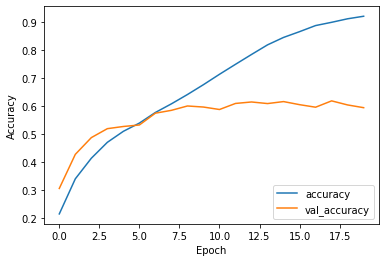

In [63]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


221/221 - 3s - loss: 1.9572 - accuracy: 0.5936 - 3s/epoch - 15ms/step
0.5936040878295898


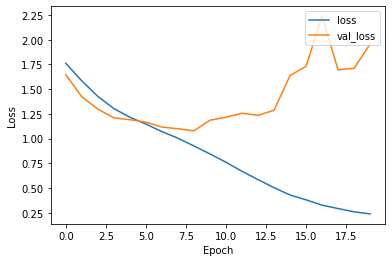

In [64]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

test_loss, test_acc = model.evaluate(X_test,  Y_test, verbose=2)
print(test_acc)

#Sources

https://www.kaggle.com/code/basel99/facial-recognition